In [32]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [34]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username/password, and connection specifics
#username = 'usernama'
#password = ''pwd     # change this
#host     = 'localhost'
#port     = '5432'            # default port that postgres listens on
#db_name  = 'MB_db'

In [35]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
#engine = create_engine( 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name) )
#print(engine.url)

Before running the commands below, initiate SQL server from a terminal by:<br>
sudo service postgresql start<br>
sudo service postgresql status<br>
(sudo passwd postgres) - set a password for postgres: one-time thing<br>
su postgres<br>

In [36]:
# for now not using this, as 
#if not database_exists(engine.url):
#    create_database(engine.url)
#print(database_exists(engine.url))

In [37]:
import json

In [38]:
data = []
# MB Masters 2017 run using 11k data
#for line in open('problems.txt', 'r'):
#MB 2016 run using 19k data
for line in open('problems_2016.txt', 'r'):
    data.append(json.loads(line))
# This creates a list of json-problems: to load this with sql, cast it to dataframe

In [39]:
# sanity check: Is the data well read?
print(data[1])

{'Method': 'Feet follow hands', 'Name': 'COUCH PROBLEM', 'Grade': '7A+', 'UserGrade': None, 'MoonBoardConfiguration': None, 'MoonBoardConfigurationId': 0, 'Setter': {'Id': '90FEA433-70AA-41AB-B93A-B3F30037E218', 'Nickname': 'marcel aarden', 'Firstname': 'marcel', 'Lastname': 'aarden', 'City': 'victoria', 'Country': 'CANADA', 'ProfileImageUrl': '/Content/Account/Images/default-profile.png?636728751296147425', 'CanShareData': True}, 'FirstAscender': False, 'Rating': 0, 'UserRating': 0, 'Repeats': 0, 'Attempts': 0, 'Holdsetup': {'Id': 1, 'Description': 'MoonBoard 2016', 'Setby': None, 'DateInserted': None, 'DateUpdated': None, 'DateDeleted': None, 'IsLocked': False, 'Holdsets': None, 'MoonBoardConfigurations': None, 'HoldLayoutId': 0, 'AllowClimbMethods': False}, 'IsBenchmark': False, 'IsAssessmentProblem': False, 'ProblemType': None, 'Moves': [{'Id': 1790343, 'Description': 'K5', 'IsStart': True, 'IsEnd': False}, {'Id': 1790344, 'Description': 'K8', 'IsStart': False, 'IsEnd': False}, {'I

In [40]:
# read a database from CSV and load it into a pandas dataframe : 
# birdh_data = pd.read_csv('births2012_downsampled.csv', index_col=0)

In [41]:
# reading data in python : good for performance comparison, but we don't need it
## insert data into database from Python (proof of concept - this won't be useful for big data, of course)
problems_raw = pd.DataFrame(data)
# MB2017
# problems = problems_raw.loc[problems_raw['Grade']!='6A+']
# MB2016
problems = problems_raw.loc[problems_raw['Grade']!='6B+']
problems = problems.reset_index()
#problems.to_sql('MB_prob_table', engine, if_exists='replace')

In [42]:
# Let's implement SQL part later, and focus on DataFrame for now. The data would not be that big in the end!
#con = None
#con = psycopg2.connect(database = db_name, user = username, password=password)

# created a symbolic link in /tmp/ to /var/run/postgresql/
# password supplied to psycopg2

# query:
#sql_query = """
#SELECT * FROM birth_data_table WHERE delivery_method='Cesarean';
#"""
#birth_data_from_sql = pd.read_sql_query(sql_query,con)
#birth_data_from_sql.head()

In [43]:
import seaborn as sns

In [44]:
font = ['5+','6A','6A+','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+']
vgrd = [2,3,3,4,4,5,5,6,7,8,8,9,10,11,12,13,14]
print(len(font))
print((vgrd))

17
[2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14]


In [45]:
grade_conversion = dict(zip(font,vgrd))

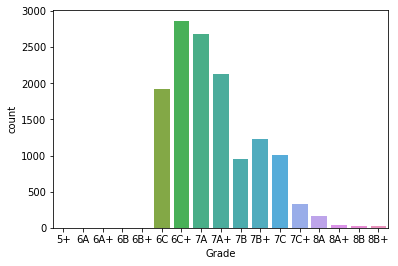

In [46]:
%matplotlib inline
sns.countplot(x="Grade", data=problems, order=['5+','6A','6A+','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
# model: two lognormal with 6A+ being faulty data collection?
# since the grades are ordinal, may I model it as lognormal...?
# Why a dip at 7B and not so obvious excess at 6B+? Is there any reason to believe that
# especially 7B route setters are more likely to estimate the grade wrong?

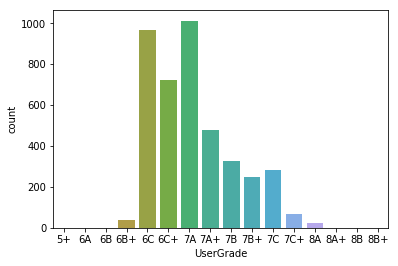

In [47]:
sns.countplot(x="UserGrade", data=problems, order=['5+','6A','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
# can this be accounted as a "real" distribution of grades 
# (since this means other users cared enough to grade the ther's problem)? 
# It does look log-normal! :P
# fit log-normal and use the param as the "ideal" grade distribution?

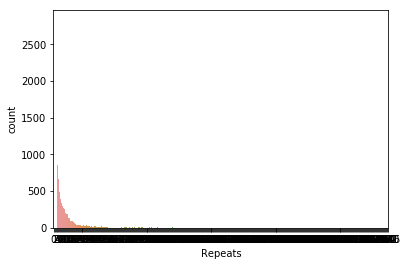

In [48]:
sns.countplot(x="Repeats", data=problems)

In [49]:
#sns.countplot(x="Method", data=problems)

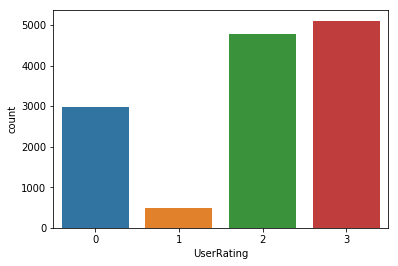

In [50]:
sns.countplot(x="UserRating", data=problems)

In [51]:
# additional feature engineering : distances between holds?
def alphabet_to_num(char_lst):
    num = np.array([ord(char.lower()) for char in char_lst])
    return num - 96
def split_xy(str_arr):
    import re
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    ret = [list(r.match(string).groups()) for string in str_arr]
    x = [ret[i][0] for i in range(len(str_arr))]
    y = [ret[i][1] for i in range(len(str_arr))]
    #strings = ['foofo21', 'bar432', 'foobar12345']
    return np.array(x),np.array(y)
def coord(hold_lst):
    xcoord , ycoord = split_xy(hold_lst)
    coord1 = np.vstack((alphabet_to_num(xcoord).astype(int),ycoord.astype(int)))
    return coord1.transpose()
def distance(hold1, hold2):
    coord1 = coord(hold1)
    coord2 = coord(hold2)
    return np.linalg.norm(coord1-coord2)

In [52]:
a,b = split_xy(['A3','B7'])

In [73]:
a = coord(['A3','B7'])
print(a[0])

[1 3]


In [54]:
#num_to_alphabet(2)

In [55]:
length = [len((problems['Moves'][i])) for i in range(len(problems))]

In [56]:
problems['Length'] = pd.Series(length)
problems = problems.loc[problems['Length']<13].reset_index()

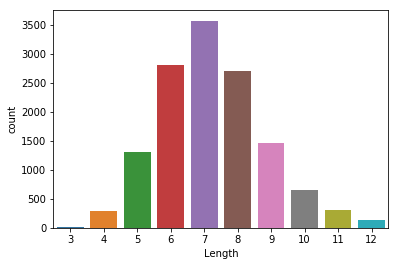

In [57]:
sns.countplot(x='Length', data=problems)

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


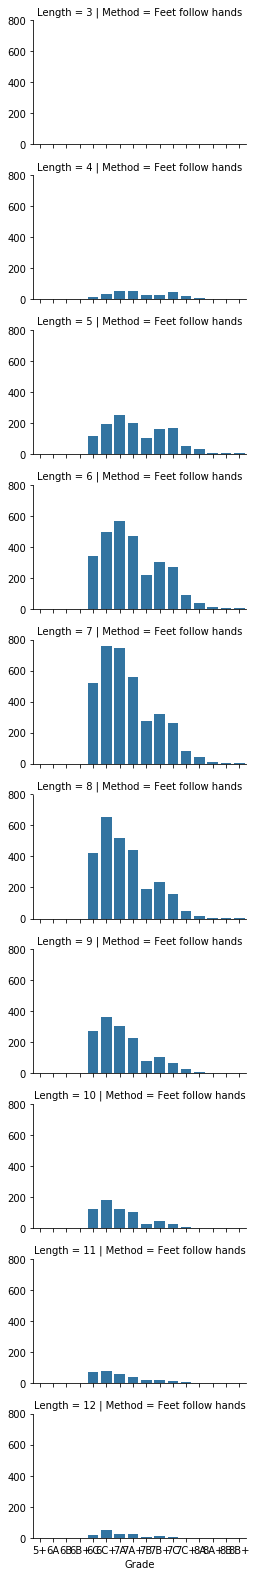

In [58]:
grid = sns.FacetGrid(data = problems, col='Method', row='Length', size=2.2, aspect=1.6)
grid.map(sns.countplot, 'Grade', order=['5+','6A','6B','6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A','8A+','8B','8B+'])
grid.add_legend();

In [59]:
print(problems['Moves'][0][0])
print(problems['Moves'][0][0]['Description'])
holds = []
for i in range(len(problems)):
    holds.append([problems['Moves'][i][j]['Description'] for j in range(problems['Length'][i])])

{'Id': 1790368, 'Description': 'B3', 'IsStart': True, 'IsEnd': False}
B3


In [217]:
print(holds[12])
print(v_labels[12])

['G2', 'E7', 'H11', 'F12', 'I16', 'G18']
7


In [60]:
start = []
end = []
interm = []
for i in range(len(problems)):
    tmp_s = []
    tmp_e = []
    tmp_i = []
    for j in range(problems['Length'][i]):
        if problems['Moves'][i][j]['IsStart'] == True:
            tmp_s.append(problems['Moves'][i][j]['Description'] )
        elif problems['Moves'][i][j]['IsEnd'] == True:
            tmp_e.append(problems['Moves'][i][j]['Description'] )
        else:
            tmp_i.append(problems['Moves'][i][j]['Description'])
    start.append(tmp_s)
    end.append(tmp_e)
    interm.append(tmp_i)

In [62]:
#t = 420
#print(start[t])
#print(holds[t])
#print(end[t])
#print(list(set(holds[t])-set(start[t])-set(end[t])))
#print(interm[t])
interm_len = [len(i) for i in interm]
max(interm_len)

10

In [63]:
print(split_xy(start[0]))
print(coord(start[0]))

(array(['B', 'A'], dtype='<U1'), array(['3', '5'], dtype='<U1'))
[[2 3]
 [1 5]]


In [114]:
def minpath_length(start,interm,end):
    #compute distance matrix
    from sklearn.metrics.pairwise import pairwise_distances
    #from skimage.graph import route_through_array
    # create numbered coordinates of interm
    interm = coord(interm)
    if len(start) == 1:
        start = coord(start)
    else:
        s1 = coord(start)
        start = (s1[0] + s1[1]) / 2.
    if len(end) == 1:
        end = coord(end)
    else:
        e1 = coord(end)
        end = (e1[0] + e1[1]) / 2.
    sort_int = np.array(sorted(interm, key=lambda x: x[1]))
    #print(sort_int)
    tgt = np.vstack((np.vstack((start,sort_int)),end))
    dist_matrix = pairwise_distances(tgt)
    #dist_matrix = dist_matrix[~np.eye(dist_matrix.shape[0],dtype=bool)].reshape(dist_matrix.shape[0],-1)

    #print(dist_matrix)
    n = len(interm) + 1
    import itertools
    permu = list(itertools.permutations(range(1,n)))
    min_dist = 1000
    min_dist_std = 100000
    for i in range(len(permu)):
        it = permu[i]
        tmp = dist_matrix[0,it[0]] + dist_matrix[it[-1],n]
        tmp_std = dist_matrix[0,it[0]]**2. + dist_matrix[it[-1],n]**2.
        for j in range(n-2):
            tmp += dist_matrix[it[j],it[j+1]]
            tmp_std += dist_matrix[it[j],it[j+1]]**2.
        min_dist = min(min_dist, tmp)
        if min_dist == tmp:
            min_dist_std = tmp_std
    min_dist_std = np.sqrt(min_dist_std / (n) - (min_dist/(n))**2. )
    #remove diagonal?
    return [min_dist, min_dist_std]

In [118]:
#n = 5126
path = [minpath_length(start[n],interm[n],end[n]) for n in range(len(problems))]

/home/ijee/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


In [144]:
print(len(path))
print(len(problems))
print(path)

13209
13209
[[22.5540441386456, 1.1545771208543871], [20.68831380576221, 1.5091726198512136], [23.54619004202055, 0.9657601281583015], [22.625974887041487, 1.0082846659405145], [23.554210516121955, 1.039825458326796], [19.55708402582784, 0.7363661605536995], [25.53689482693512, 0.9883711873794805], [22.238259556865184, 1.141954272573271], [20.93791626109063, 1.3294441269204187], [14.779959875110041, 1.687320103191322], [18.133314794254854, 1.2037154608870921], [20.634149028369315, 0.9051385280728189], [20.449659909380486, 1.293234852463798], [20.620470776878612, 1.3385990428787127], [20.335998106920954, 1.7486815718741635], [16.638310528300117, 1.4825363141390828], [16.919796900954, 0.7401289833248168], [17.91925977444875, 0.864422240186133], [18.903391849743823, 1.0363099141644463], [25.145772029716337, 1.6765552400808799], [26.23757772290023, 1.6080484655732523], [20.51014120343272, 0.9565468060413914], [21.246211251235323, 0.7375230835135015], [18.19803902718557, 1.246296522742978],

In [94]:
def xlims(list):
    # return (leftmost, rightmost) x coordinate of a given problem
    n = len(list)
    #coords = [alphabet_to_num(split_xy(list[i])[0]) for i in range(n)]
    coords = coord(list).transpose()
#    xcoords = [coords[i][0] for i in range(n)]
#    xcoords = [alphabet_to_num(coords[i]) for i in range(n)]
    return [np.min(coords[0]),np.max(coords[0])]

In [95]:
#xlims(holds[0])

['B3', 'A5', 'G8', 'E7', 'C10', 'D12', 'D15', 'G15', 'G17', 'G18']


[1, 7]

In [146]:
df_holds = pd.Series(holds)
c = pd.DataFrame(path,columns = ['path','std'])
#df_holds.head(5)

In [149]:
c.tail(5)

,path,std
13204,17.230670,0.569351
13205,14.613221,0.598457
13206,22.130899,0.477938
13207,20.469425,1.113600
13208,22.270075,1.143141


In [150]:
a = df_holds.apply(xlims)
b = pd.DataFrame(a,columns=['lr'])
b[['l','r']] = pd.DataFrame(b.lr.values.tolist(), index= b.index)
b = b.drop(['lr'],axis=1)
b['width'] = b['r']-b['l']
#b.head(5)

['B3', 'A5', 'G8', 'E7', 'C10', 'D12', 'D15', 'G15', 'G17', 'G18']
['K5', 'K8', 'H10', 'B11', 'B15', 'A15', 'A18']
['F5', 'J5', 'G9', 'E12', 'J13', 'H16', 'I18']
['D3', 'C5', 'E8', 'A9', 'E12', 'D11', 'H14', 'E16', 'E18']
['G2', 'I4', 'F7', 'I8', 'I9', 'E10', 'F13', 'H14', 'G17', 'I18']
['I4', 'G4', 'H8', 'F12', 'H14', 'E16', 'E18', 'E8']
['B3', 'E6', 'C8', 'H8', 'G11', 'I12', 'E15', 'G18']
['G4', 'B4', 'D6', 'B7', 'D10', 'I12', 'D13', 'I16', 'I15', 'H18']
['I5', 'J8', 'E11', 'H14', 'G15', 'H16', 'E18', 'J10']
['E13', 'E9', 'F5', 'E14', 'A18']
['F5', 'E11', 'J12', 'I16', 'K18']
['I4', 'J6', 'J10', 'E7', 'F10', 'I13', 'G18']
['G2', 'E7', 'H11', 'F12', 'I16', 'G18']
['G2', 'G8', 'F10', 'K11', 'J14', 'K18']
['G4', 'G6', 'K9', 'F12', 'E12', 'B15', 'D18']
['G4', 'I10', 'H12', 'K14', 'I18']
['C5', 'C7', 'D10', 'C12', 'G13', 'F15', 'G18']
['I5', 'H8', 'E10', 'E13', 'D18', 'B16', 'G7']
['D7', 'E9', 'D12', 'G14', 'I18', 'G4', 'F15']
['J12', 'C14', 'J6', 'H5', 'D11', 'D16', 'E8', 'A18']
['J6', '

['D6', 'F6', 'D10', 'G12', 'C13', 'E18', 'H8']
['H5', 'C7', 'F10', 'B11', 'G14', 'E16', 'K18']
['F5', 'G2', 'G6', 'D10', 'I12', 'E15', 'E18']
['F5', 'G13', 'E18', 'G2', 'H10', 'D8']
['D5', 'G10', 'E9', 'I5', 'F11', 'I14', 'E16', 'B4', 'F7', 'D18']
['I4', 'F7', 'D10', 'C5', 'C12', 'F15', 'E16', 'H18', 'H9']
['A5', 'E7', 'E9', 'G11', 'E14', 'I15', 'I18']
['E6', 'G9', 'I12', 'E15', 'B18', 'K5']
['H10', 'J2', 'G2', 'E10', 'B13', 'C15', 'C18']
['G9', 'G13', 'G18', 'B8', 'B3']
['G2', 'D6', 'H11', 'D14', 'D15', 'C18']
['D5', 'B4', 'B9', 'F12', 'D3', 'C18', 'E14', 'F16']
['F5', 'J9', 'G14', 'B12', 'K5', 'D18']
['G4', 'G9', 'H12', 'I14', 'E16', 'D18']
['I4', 'E7', 'H11', 'I13', 'E15', 'H18', 'I7', 'D3', 'G2', 'K7']
['A5', 'E8', 'B11', 'F13', 'H16', 'G18', 'G2', 'F11', 'F6']
['G6', 'D5', 'B3', 'F9', 'J11', 'J14', 'I15', 'D16', 'C18']
['I4', 'I6', 'D7', 'E9', 'B10', 'B12', 'A15', 'C16', 'F16', 'H18']
['G4', 'J5', 'G9', 'C10', 'B11', 'D15', 'E18']
['G4', 'B6', 'E8', 'A9', 'F11', 'C13', 'I14', 'I15

['B3', 'C7', 'G9', 'F9', 'H12', 'K5', 'E14', 'E16', 'B18']
['F5', 'E10', 'F8', 'A14', 'E18', 'D17', 'D12']
['C5', 'D5', 'G7', 'G9', 'K5', 'J12', 'F9', 'H12', 'I14', 'E16', 'D18']
['F5', 'B7', 'A9', 'C12', 'A14', 'F8', 'D16', 'D17', 'G18']
['F5', 'J8', 'K11', 'K6', 'K14', 'H16', 'G17', 'D18', 'J10']
['F5', 'H10', 'I12', 'I14', 'H16', 'G17', 'D18', 'K10']
['H5', 'K8', 'H11', 'H14', 'E16', 'D18']
['I5', 'E12', 'D15', 'G18', 'C11', 'F9', 'E7']
['F5', 'E9', 'C13', 'A9', 'C14', 'G15', 'E16', 'I18']
['G4', 'H11', 'D13', 'C13', 'D17', 'A18', 'K7']
['B3', 'C7', 'C10', 'G11', 'D13', 'E15', 'C18']
['A5', 'C5', 'A9', 'E9', 'D11', 'I12', 'F6', 'G15', 'K18']
['B3', 'D8', 'D10', 'I12', 'F15', 'I16', 'E18']
['F5', 'H11', 'J8', 'E13', 'I16', 'G18']
['J5', 'G8', 'C8', 'D10', 'A5', 'C13', 'G14', 'H14', 'G18']
['C5', 'A5', 'A9', 'E10', 'G15', 'F14', 'E18']
['E8', 'F10', 'C13', 'E16', 'A18', 'J5']
['B4', 'D3', 'D8', 'D10', 'H12', 'H15', 'I18']
['B3', 'C8', 'E12', 'K6', 'F12', 'I12', 'I16', 'K18', 'H8']
['F

['K5', 'G6', 'H10', 'D12', 'E16', 'C18']
['K5', 'F14', 'D9', 'K18', 'J9', 'G2', 'I4', 'J7']
['E6', 'E9', 'B10', 'E12', 'A14', 'E16', 'A18']
['K5', 'A5', 'C5', 'C7', 'G9', 'H10', 'J12', 'I14', 'G15', 'G17', 'E18']
['H5', 'J2', 'H9', 'F9', 'F12', 'C15', 'G18']
['H5', 'G2', 'K10', 'F12', 'E14', 'A14', 'D18']
['K5', 'J8', 'I18', 'H10', 'G13', 'H14', 'G17']
['F5', 'I18', 'F11', 'C10', 'K5', 'G14', 'F7']
['G4', 'C10', 'G18', 'H8', 'D15', 'D16', 'G7']
['G2', 'C7', 'B12', 'D13', 'C18']
['G2', 'C7', 'B12', 'D13', 'C18']
['D5', 'C9', 'H11', 'E14', 'H18']
['G2', 'E7', 'I10', 'H12', 'H13', 'D14', 'E18']
['C5', 'G6', 'E9', 'B11', 'G13', 'C16', 'G18']
['B4', 'E6', 'D9', 'I11', 'F14', 'E16', 'B18']
['B4', 'D10', 'C12', 'E13', 'C15', 'G17', 'E18', 'D3', 'F5', 'C7']
['E11', 'G11', 'J13', 'H12', 'H8', 'B7', 'D8', 'K6', 'H16', 'G17', 'E18']
['D3', 'B4', 'G7', 'C9', 'D10', 'H14', 'C18']
['F5', 'C8', 'B8', 'A12', 'D15', 'G14', 'H16', 'I16', 'K18', 'B4', 'B7']
['C6', 'B6', 'B11', 'E9', 'E14', 'B18']
['F5', 

['K5', 'H8', 'G8', 'G13', 'I18', 'E8']
['E15', 'A9', 'B11', 'G18', 'B3', 'C13']
['J13', 'C15', 'I14', 'K11', 'I5', 'B10', 'G8', 'B18']
['D3', 'I4', 'E8', 'F11', 'F14', 'K14', 'K18']
['D3', 'D10', 'I14', 'H16', 'K18', 'H7']
['F5', 'G2', 'G9', 'C10', 'F14', 'I16', 'E18']
['F5', 'H10', 'F14', 'I16', 'K18']
['B3', 'G4', 'B9', 'F10', 'E12', 'F15', 'C18']
['I5', 'F7', 'E10', 'D12', 'B15', 'E18']
['G4', 'E7', 'H8', 'C10', 'I12', 'C13', 'E16', 'A18']
['K5', 'J8', 'I11', 'D12', 'A14', 'C18', 'D16']
['E6', 'J5', 'H10', 'F14', 'B16', 'A18', 'B11', 'E16']
['F5', 'G9', 'B10', 'E12', 'C15', 'E16', 'G18']
['D10', 'G2', 'D3', 'F8', 'I14', 'G18']
['D3', 'A5', 'C7', 'D10', 'H14', 'G18']
['D10', 'G18', 'D3', 'C7', 'A5', 'G13', 'E16']
['I4', 'F7', 'C13', 'B18', 'G9', 'F11', 'E11', 'D16', 'C7', 'G2']
['H5', 'B6', 'E9', 'F10', 'H12', 'F15', 'I18']
['E16', 'B11', 'D18', 'F5', 'H9']
['G4', 'H8', 'C10', 'E12', 'H14', 'G15', 'K18']
['G2', 'E8', 'H11', 'C13', 'E18']
['J5', 'E6', 'E8', 'B10', 'E12', 'E16', 'I18']

['J5', 'G7', 'C18', 'G14', 'F15', 'D10', 'F12']
['D5', 'B8', 'A12', 'K7', 'F16', 'H18', 'I13', 'B4']
['F5', 'G2', 'G11', 'F15', 'G18']
['B4', 'D6', 'D3', 'C7', 'D10', 'A13', 'D13', 'F15', 'D16', 'C18']
['H5', 'B4', 'C10', 'D15', 'A18']
['I4', 'I6', 'E8', 'E11', 'C12', 'D16', 'A18']
['C5', 'D6', 'F8', 'F9', 'I5', 'H12', 'D14', 'E14', 'D18']
['G4', 'E8', 'H9', 'E13', 'E16', 'B18']
['I5', 'F8', 'I8', 'G11', 'C12', 'F15', 'G16', 'H18']
['H5', 'J2', 'K8', 'H9', 'I12', 'F15', 'G16', 'E18']
['H10', 'F5', 'F7', 'C16', 'B18', 'E13', 'F15']
['C5', 'B7', 'D12', 'F10', 'H7', 'D16', 'B18']
['F5', 'I4', 'H8', 'E8', 'H10', 'H13', 'E15', 'E18']
['I5', 'F9', 'H9', 'K12', 'J14', 'J16', 'G18']
['B4', 'D3', 'C7', 'B11', 'F6', 'D15', 'E15', 'H18']
['I4', 'G8', 'G11', 'C12', 'D13', 'D17', 'H18', 'J6']
['C5', 'F7', 'F10', 'H12', 'H14', 'J14', 'G16', 'D17', 'B18']
['A5', 'C5', 'C7', 'D10', 'C12', 'C15', 'E16', 'D18', 'B8', 'F14']
['I5', 'K5', 'J7', 'J8', 'I10', 'I18', 'K18', 'J13', 'I15', 'I16', 'K16']
['E11'

['F6', 'J5', 'F14', 'E16', 'G8', 'G2', 'E10', 'F10', 'E18']
['E6', 'F9', 'C10', 'E13', 'C14', 'F16', 'G18']
['G4', 'B6', 'E10', 'E9', 'H11', 'I14', 'I15', 'G18']
['J2', 'I6', 'G2', 'B6', 'B10', 'D9', 'D18']
['F5', 'J6', 'H9', 'E10', 'G14', 'E16', 'I18']
['F5', 'J5', 'I10', 'E13', 'D15', 'E18']
['I6', 'J2', 'B10', 'D9', 'G2', 'D18']
['J5', 'H9', 'I9', 'F13', 'F12', 'C15', 'C9', 'C18']
['H5', 'K5', 'J8', 'K11', 'I14', 'E15', 'E18']
['K5', 'E6', 'C10', 'E14', 'H8', 'A18']
['D6', 'H5', 'G9', 'D10', 'E12', 'F15', 'D16', 'H18']
['B3', 'K5', 'F13', 'G17', 'E6', 'H8', 'J10', 'D18']
['H5', 'K6', 'H9', 'E10', 'H14', 'E15', 'A10', 'D17', 'A18']
['I5', 'F7', 'H11', 'F9', 'K8', 'I13', 'I15', 'K18']
['B4', 'D6', 'F9', 'D10', 'C12', 'D13', 'F15', 'D16', 'C18']
['G2', 'H5', 'I8', 'D10', 'H14', 'E18']
['J5', 'G8', 'F10', 'K10', 'B12', 'E16', 'G17', 'K18']
['G2', 'B3', 'H7', 'F10', 'E10', 'E12', 'A14', 'D16', 'E7', 'A18']
['H5', 'I6', 'D15', 'B16', 'E8', 'F11', 'D11', 'C6', 'C18']
['G2', 'I4', 'H8', 'E7

['F5', 'I4', 'G9', 'E10', 'E12', 'C13', 'E15', 'D17', 'E18']
['I5', 'H9', 'F9', 'I12', 'F15', 'H18']
['F5', 'J5', 'J8', 'E10', 'G13', 'E15', 'E18']
['K5', 'G2', 'E7', 'G8', 'H11', 'J13', 'H16', 'K18']
['F5', 'A5', 'B9', 'A9', 'D12', 'A12', 'D15', 'A18']
['G4', 'F7', 'H8', 'F11', 'J9', 'K6', 'F14', 'J16', 'I18']
['J5', 'E6', 'J9', 'F13', 'G15', 'B9', 'D18']
['G2', 'C7', 'H7', 'J10', 'I12', 'K18']
['B6', 'E7', 'B11', 'G12', 'G15', 'G17', 'B18']
['I4', 'F5', 'J8', 'K11', 'K14', 'H16', 'G17', 'E18']
['K5', 'K8', 'H9', 'H11', 'D11', 'D6', 'D15', 'D18']
['I5', 'F5', 'G8', 'C8', 'B10', 'F11', 'C13', 'G14', 'E16', 'G18']
['J5', 'E7', 'E10', 'G14', 'E18']
['I5', 'D10', 'I8', 'D13', 'H14', 'E18']
['F5', 'B6', 'A9', 'B10', 'E8', 'E12', 'B13', 'E14', 'B18']
['F5', 'H11', 'E15', 'I18']
['G4', 'E7', 'H9', 'E11', 'H13', 'D16', 'D18']
['A5', 'C5', 'C8', 'E10', 'D15', 'D11', 'A18']
['H5', 'K8', 'J11', 'J10', 'E11', 'F10', 'C12', 'C14', 'A16', 'C18']
['G4', 'J7', 'J8', 'K11', 'I15', 'K16', 'I18']
['F5',

['I4', 'E6', 'H8', 'C13', 'G17', 'D18']
['B3', 'C5', 'E7', 'H8', 'E11', 'H13', 'F14', 'E6', 'E18']
['J2', 'F5', 'J8', 'H10', 'E10', 'C13', 'E16', 'E18']
['C5', 'E6', 'H9', 'H12', 'J14', 'H16', 'G17', 'D18']
['I5', 'H8', 'C9', 'G14', 'C16', 'C18']
['J5', 'H5', 'F12', 'H16', 'H8', 'C8', 'E13', 'I15', 'K18']
['I4', 'E8', 'G10', 'C10', 'D15', 'E18']
['K5', 'E6', 'G9', 'C10', 'E13', 'A14', 'D17', 'G18']
['K5', 'J6', 'I7', 'H10', 'E15', 'C9', 'G18']
['D5', 'C5', 'A9', 'E11', 'A14', 'E15', 'I18']
['K6', 'J2', 'J8', 'J9', 'E11', 'I14', 'G18']
['G4', 'E6', 'D9', 'A12', 'D15', 'D18']
['G4', 'J8', 'J10', 'K11', 'D6', 'G13', 'D15', 'D11', 'B16', 'E18']
['B3', 'D6', 'G8', 'J11', 'H12', 'G14', 'C15', 'D16', 'A10', 'B18']
['D5', 'H5', 'E8', 'G10', 'B10', 'D14', 'E16', 'J16', 'I18']
['G2', 'B3', 'K11', 'E7', 'K9', 'K14', 'E14', 'H8', 'E18']
['G2', 'I4', 'F6', 'K5', 'F5', 'H10', 'G14', 'G18']
['F5', 'G8', 'H10', 'E13', 'E12', 'A14', 'E16', 'D17', 'G18']
['D3', 'A5', 'C10', 'B9', 'F10', 'F9', 'H12', 'I1

['B3', 'G2', 'G9', 'B11', 'D15', 'D17', 'H18']
['D5', 'B6', 'G10', 'B10', 'D14', 'D7', 'A15', 'D18']
['I4', 'F5', 'H9', 'J11', 'I12', 'I14', 'G17', 'I18']
['F5', 'H10', 'G14', 'C13', 'E18']
['I5', 'G6', 'I8', 'I12', 'G12', 'G15', 'I16', 'G18']
['J5', 'E8', 'I9', 'H12', 'K14', 'I18']
['J5', 'E9', 'I9', 'H12', 'H16', 'I7', 'D18']
['G2', 'I4', 'F7', 'J8', 'H11', 'F14', 'G18']
['E6', 'H5', 'D8', 'A9', 'B12', 'C13', 'I13', 'H15', 'K10', 'K18']
['C15', 'E6', 'F11', 'G18', 'J5']
['C5', 'B3', 'E8', 'B10', 'F11', 'C13', 'F14', 'D18']
['E6', 'I5', 'J8', 'E10', 'G13', 'I10', 'C13', 'D15', 'F9', 'G2', 'J2', 'B18']
['G2', 'J2', 'F6', 'F8', 'C11', 'D14', 'D16', 'G18']
['J5', 'G2', 'K7', 'H11', 'C8', 'F14', 'E18']
['B4', 'D3', 'H7', 'D10', 'H14', 'C15', 'C18']
['G2', 'J2', 'H10', 'B6', 'D15', 'B10', 'I5', 'A18']
['C5', 'D7', 'G9', 'I14', 'G14', 'G17', 'D18']
['G4', 'J5', 'E6', 'A9', 'A14', 'H8', 'F11', 'D18']
['A5', 'C5', 'D9', 'E13', 'I16', 'I18']
['F5', 'E8', 'A9', 'E12', 'D14', 'G15', 'J11', 'F16'

['F5', 'A5', 'I14', 'C10', 'J10', 'G8', 'D18']
['I6', 'H5', 'F9', 'G11', 'C13', 'D16', 'C18']
['F5', 'E9', 'B10', 'G13', 'G17', 'K18']
['F6', 'B4', 'J10', 'C10', 'I13', 'E16', 'H18']
['D6', 'C9', 'C12', 'D16', 'H18']
['B4', 'D16', 'B13', 'C9', 'C18']
['D6', 'F6', 'C10', 'F10', 'D15', 'A16', 'E18']
['C5', 'E6', 'F11', 'A16', 'C8', 'B12', 'C14', 'E18']
['B10', 'E13', 'F5', 'G10', 'H18']
['B3', 'C8', 'C10', 'D18', 'G14', 'G15', 'H10']
['J5', 'J10', 'D9', 'D10', 'A14', 'A18']
['D6', 'F6', 'F9', 'I12', 'F15', 'G2', 'H18']
['J5', 'E7', 'D10', 'D12', 'G15', 'H18']
['F5', 'I6', 'F10', 'C11', 'D13', 'C14', 'C9', 'B16', 'E16', 'G2', 'E18']
['G2', 'D6', 'D8', 'E11', 'J12', 'G15', 'K18']
['I5', 'I8', 'I11', 'I16', 'I18']
['K5', 'J8', 'E13', 'B16', 'E11', 'G18']
['F5', 'C11', 'G13', 'E18']
['K5', 'G17', 'C13', 'H10', 'J8', 'E18']
['J5', 'I14', 'E10', 'G9', 'E18']
['A5', 'C6', 'G2', 'F14', 'K14', 'J9', 'C10', 'D9', 'K18']
['E6', 'I5', 'G9', 'C8', 'F11', 'C13', 'D15', 'A18']
['K5', 'B16', 'E12', 'D11

['G4', 'F8', 'H11', 'E12', 'F15', 'D10', 'E18']
['K5', 'J9', 'F13', 'J16', 'F7', 'K18']
['F5', 'G8', 'F12', 'E12', 'B16', 'G18']
['G6', 'J5', 'H8', 'D11', 'D15', 'B6', 'A18']
['F5', 'H8', 'C8', 'F12', 'H14', 'G18']
['K5', 'H5', 'C5', 'H9', 'H10', 'D11', 'C13', 'D15', 'D18']
['A5', 'D7', 'A9', 'F10', 'E13', 'H16', 'G18']
['B6', 'D5', 'E9', 'C10', 'G12', 'F13', 'H16', 'G18']
['G6', 'I4', 'J8', 'J10', 'G2', 'I11', 'I14', 'E15', 'G18']
['K5', 'F5', 'F10', 'F14', 'A9', 'E16', 'B18']
['G2', 'J5', 'J8', 'G8', 'H12', 'G13', 'D15', 'E15', 'E18']
['G4', 'C5', 'J7', 'K7', 'I10', 'I11', 'H14', 'F15', 'C13', 'K13', 'H18']
['G4', 'H10', 'C13', 'D18']
['F5', 'H8', 'D11', 'D14', 'F6', 'B7', 'A18']
['B3', 'G2', 'G15', 'C7', 'H7', 'G11', 'J13', 'K5', 'K18']
['J2', 'J6', 'J8', 'K11', 'I13', 'I16', 'E18']
['A5', 'D5', 'B9', 'C10', 'B13', 'B16', 'G18']
['F5', 'H8', 'E10', 'E12', 'E16', 'C15', 'A18']
['I5', 'J2', 'I10', 'J9', 'G14', 'H14', 'C13', 'E16', 'B9', 'C18']
['I5', 'J2', 'I10', 'I9', 'G15', 'H14', '

['I5', 'D3', 'H9', 'F9', 'I12', 'G16', 'F6', 'D16', 'H14', 'D13', 'D10', 'H18']
['E6', 'G6', 'E10', 'G13', 'G15', 'I18']
['I5', 'F5', 'E15', 'E11', 'G14', 'G9', 'G2', 'E18']
['K5', 'H11', 'C15', 'H18']
['J5', 'G4', 'J8', 'H11', 'I14', 'G17', 'I18']
['B3', 'J2', 'F7', 'J10', 'H12', 'F16', 'J14', 'D13', 'I18']
['J5', 'H5', 'H9', 'I9', 'D13', 'F15', 'C18']
['D3', 'D6', 'G7', 'D10', 'I12', 'F15', 'I18']
['H5', 'D3', 'C7', 'F10', 'F13', 'H16', 'I18']
['F5', 'F6', 'D10', 'J9', 'F15', 'K8', 'I18']
['B6', 'D5', 'E9', 'F10', 'E11', 'I12', 'H12', 'K7', 'G15', 'K18']
['F5', 'G2', 'E13', 'I15', 'H16', 'K7', 'H9', 'H10', 'K18']
['F5', 'F10', 'E10', 'I12', 'H12', 'G15', 'K18']
['B3', 'F6', 'K6', 'K7', 'G11', 'J12', 'F16', 'H18']
['I4', 'E6', 'K9', 'I12', 'C9', 'H16', 'G15', 'C15', 'K14', 'D18']
['H5', 'D6', 'F9', 'I10', 'I12', 'E16', 'A16', 'F13', 'A18']
['C5', 'C10', 'I11', 'E14', 'G18']
['F5', 'H10', 'C13', 'D15', 'G2', 'K5', 'A18']
['G2', 'I4', 'H14', 'C13', 'F15', 'H8', 'H10', 'K6', 'D18']
['C5'

['I5', 'H9', 'D10', 'E12', 'C15', 'G16', 'H18']
['I5', 'K9', 'H12', 'I13', 'D17', 'C18']
['F5', 'H9', 'E11', 'E13', 'E16', 'G18']
['G2', 'I4', 'G8', 'J8', 'G14', 'B15', 'A18']
['G2', 'J2', 'H9', 'F12', 'F11', 'B13', 'D15', 'D18']
['I6', 'H5', 'E10', 'J9', 'G15', 'I15', 'D3', 'K18']
['D6', 'F6', 'I8', 'H9', 'K13', 'H15', 'H14', 'E16', 'D18']
['D6', 'F6', 'I8', 'H9', 'K13', 'H15', 'E16', 'H14', 'K18']
['B4', 'B10', 'E14', 'D16', 'G16', 'E7', 'I18']
['C5', 'G17', 'E9', 'F11', 'F15', 'C18']
['D3', 'B6', 'E8', 'E10', 'I14', 'F15', 'D16', 'B18']
['D3', 'B4', 'D9', 'C12', 'G14', 'I14', 'H18']
['D3', 'B4', 'D9', 'B10', 'D15', 'D18']
['I6', 'H5', 'E10', 'J9', 'G15', 'D3', 'K18']
['B3', 'B8', 'D12', 'B13', 'E18']
['A5', 'D5', 'I4', 'E8', 'F10', 'K11', 'K10', 'I15', 'H16', 'D18']
['D17', 'E12', 'E13', 'G8', 'H18', 'I7', 'I11', 'K5']
['G4', 'E6', 'E10', 'H10', 'H13', 'F14', 'G18']
['E6', 'F11', 'D15', 'E16', 'A18']
['J2', 'K8', 'G7', 'H12', 'I15', 'C12', 'D16', 'C18']
['I5', 'H8', 'H10', 'E12', 'I

['F5', 'I5', 'D10', 'E12', 'H9', 'B15', 'D17', 'E18']
['H5', 'I8', 'B8', 'G11', 'F13', 'B15', 'G18']
['K6', 'H5', 'F7', 'G9', 'B10', 'E13', 'D17', 'B18']
['J5', 'F8', 'H7', 'D8', 'H12', 'H15', 'H18']
['F5', 'H9', 'K10', 'G14', 'I18']
['B4', 'D6', 'C9', 'D10', 'A13', 'D16', 'C18']
['K5', 'J7', 'J9', 'H13', 'H11', 'H16', 'G16', 'H18']
['G4', 'F8', 'D10', 'G11', 'E15', 'D17', 'A18']
['F5', 'H10', 'E13', 'H16', 'D18']
['B3', 'E7', 'C10', 'G14', 'G15', 'K18']
['B6', 'H5', 'G9', 'F11', 'C13', 'F14', 'I14', 'K18']
['D3', 'E6', 'I10', 'H9', 'E14', 'I18']
['D18', 'F12', 'F10', 'G8', 'G17', 'H16', 'J13', 'J5']
['J5', 'H10', 'C13', 'E16', 'C16', 'I18']
['B3', 'A5', 'F5', 'G8', 'J10', 'H12', 'K14', 'E15', 'D18']
['B6', 'E6', 'H10', 'F13', 'I18']
['A5', 'D9', 'A12', 'E13', 'E15', 'I16', 'K18']
['J5', 'G6', 'E9', 'B12', 'E14', 'A18']
['E6', 'E9', 'C8', 'E14', 'C13', 'D18']
['H5', 'G6', 'C8', 'E12', 'E14', 'I15', 'H18']
['A5', 'B9', 'C10', 'K7', 'H10', 'J13', 'H16', 'G18']
['E6', 'C8', 'F12', 'F10', 

In [151]:
b['width'] = b['r']-b['l']

In [152]:
# generate classes for mlb!
mlb_class = []
for i in range(11):
    for j in range(18):
        mlb_class.append(chr(i+65)+'%d'%(j+1))

In [186]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=mlb_class)
df_holds_enc = pd.DataFrame(mlb.fit_transform(df_holds), columns=mlb_class)
#df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Col3')),
#                          columns=mlb.classes_,
#                          index=df.index))

In [187]:
# feature vector: hold positions multilabel binary encoded
df_holds_enc = df_holds_enc.join(problems['Length'])
df_holds_enc = df_holds_enc.join(b)
df_holds_enc = df_holds_enc.join(c)
inds = np.where(df_holds_enc['std'].isna())
df_holds_enc = df_holds_enc.dropna()


In [211]:
df_holds_enc['std'].isnull().sum()
df_holds_enc.head(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,K15,K16,K17,K18,Length,l,r,width,path,std
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,10,1,7,6,22.554044,1.154577
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,1,11,10,20.688314,1.509173
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,5,10,5,23.546190,0.965760
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,9,1,8,7,22.625975,1.008285
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,5,9,4,23.554211,1.039825


In [195]:
print(list(inds)[0])

[11316]


In [ ]:
# add width of problems (max(x)-min(x)) to the features
# leftmost hold

In [190]:
labels = problems['Grade']

In [196]:
v_labels = problems.replace({'Grade': grade_conversion})['Grade']
v_labels = v_labels.drop(list(inds)[0])
print(len(v_labels))

13208


Text(0.5,0,'V grade')

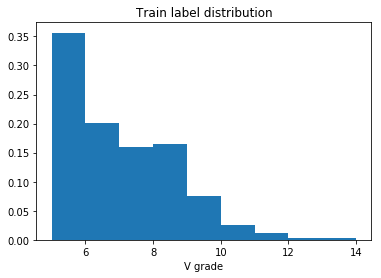

In [197]:
plt.hist(v_labels,bins= range(min(v_labels),max(v_labels)+1),density=True)
plt.title('Train label distribution')
plt.xlabel('V grade')
# IF the classifier classifies everything to 5, the accuracy will be 35%

In [198]:
print(labels.head(5))
print(v_labels.head(5))
print(min(v_labels),max(v_labels))

0     7A
1    7A+
2    6C+
3    6C+
4    6C+
Name: Grade, dtype: object
0    6
1    7
2    5
3    5
4    5
Name: Grade, dtype: int64
5 14


In [199]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_holds_enc, v_labels, test_size = 0.25, random_state = 42)

In [200]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (9906, 204)
Training Labels Shape: (9906,)
Testing Features Shape: (3302, 204)
Testing Labels Shape: (3302,)


In [201]:
print(train_features.head(5))

       A1  A2  A3  A4  A5  A6  A7  A8  A9  A10    ...     K15  K16  K17  K18  \
10690   0   0   0   0   0   0   0   0   0    0    ...       0    0    0    0   
568     0   0   0   0   0   0   0   0   0    0    ...       0    0    0    0   
11322   0   0   0   0   0   0   0   0   0    0    ...       0    0    0    0   
12904   0   0   0   0   0   0   0   0   0    0    ...       0    0    0    0   
11311   0   0   0   0   0   0   0   0   0    0    ...       0    0    0    0   

       Length  l   r  width       path       std  
10690       4  5  10      5  15.165125  0.668248  
568         9  1  10      9  34.272440  1.377270  
11322       9  2  11      9  20.068392  0.457581  
12904       6  5   9      4  16.349190  0.952974  
11311       6  3   8      5  19.204297  1.431013  

[5 rows x 204 columns]


In [202]:
from sklearn.metrics import precision_score

In [203]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [204]:
features_name = train_features.columns.values.tolist()

Feature ranking:
1. feature 203 (0.073477)
2. feature 202 (0.068340)
3. feature 198 (0.043573)
4. feature 201 (0.036545)
5. feature 199 (0.029109)
6. feature 200 (0.027869)
7. feature 94 (0.012279)
8. feature 109 (0.010414)
9. feature 71 (0.010163)
10. feature 125 (0.009807)
11. feature 135 (0.009622)
12. feature 89 (0.009521)
13. feature 79 (0.008811)
14. feature 161 (0.008799)
15. feature 86 (0.008607)
16. feature 99 (0.008376)
17. feature 111 (0.008102)
18. feature 130 (0.007992)
19. feature 104 (0.007965)
20. feature 56 (0.007911)
21. feature 84 (0.007795)
22. feature 85 (0.007741)
23. feature 83 (0.007504)
24. feature 48 (0.007502)
25. feature 100 (0.007346)
26. feature 166 (0.007263)
27. feature 63 (0.007177)
28. feature 133 (0.007127)
29. feature 102 (0.007120)
30. feature 121 (0.007083)
31. feature 139 (0.007042)
32. feature 20 (0.007028)
33. feature 116 (0.006933)
34. feature 136 (0.006875)
35. feature 53 (0.006835)
36. feature 77 (0.006823)
37. feature 143 (0.006818)
38. feat

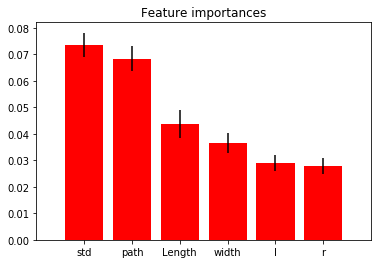

In [205]:
# let's plot feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
top4_indices = indices[:6]
# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
lbl = tuple([features_name[top4_indices[i]] for i in range(6)])
print(lbl)
# Plot the feature importances of the forest
#plt.bar(range(train_features.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.title("Feature importances")
#plt.xticks(range(train_features.shape[1]), indices)
#plt.xlim([-1, train_features.shape[1]])
# Plot the feature importances of the forest
plt.bar(range(6), importances[top4_indices],
       color="r", yerr=std[top4_indices], align="center")
plt.title("Feature importances")
plt.xticks(range(6), lbl)
plt.xlim([-1, 6])
plt.show()

In [206]:
pred_probability = rf.predict_proba(test_features)

In [ ]:
# save the model to disk
filename = 'RF_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [ ]:
#import matplotlib.pyplot as plt
prob_num = 76
real_grade = np.array(test_labels)
plt.plot(range(min(v_labels),max(v_labels)+1),pred_probability[prob_num])
plt.xlabel('Predicted Grade')
plt.ylabel('Probability')
plt.title('Real Grade : %d'%(real_grade[prob_num]))
# plot probability distribution of each predictions
# 45 is an example of good classification
# 90 has two peaks... 
# ways to quantify this? difference between two peaks should be more than 0.3?
# what about more wide distribution?

In [207]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.02 degrees.


Text(0.5,0,'V grade')

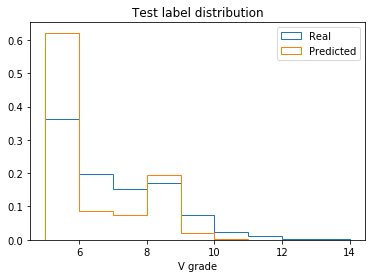

In [208]:
plt.hist(test_labels, bins= range(min(v_labels),max(v_labels)+1), density=True, histtype='step',label='Real')
plt.hist(predictions, bins= range(min(v_labels),max(v_labels)+1), density=True, histtype='step',label='Predicted')
plt.title('Test label distribution')
plt.legend(loc='upper right')
plt.xlabel('V grade')

In [ ]:
print(predictions)

[-2 -1 -3 ...  1  1  2]
0.43125378558449423


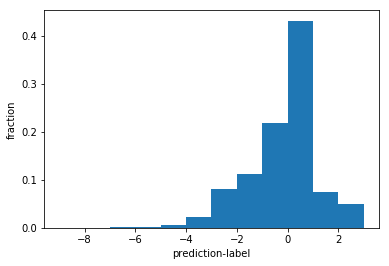

In [209]:
pred = np.array(predictions)
tlabel = np.array(test_labels)
tst = pred-tlabel
print(tst)
binwidth=1
plt.hist(tst,bins=range(min(tst),max(tst),binwidth),density=True)
plt.xlabel('prediction-label')
plt.ylabel('fraction')
print((len(tst)-np.count_nonzero(tst))/len(tst))
# 38% accuracy (exact classification)
# Classifier tend to classify problems easier than it actually is: prob because not many hard problems exist

In [210]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
# by removing 6A+, the accuracy improves from 76 to 78%
# by adding length, 78 to 79%
# RFclassifier -> 80.3%
# why was the stanford group's accuracy so low? -> because they only looked at rate at which 
# they actually got the label correct
# LET'S IMPLEMENT IMBALANCE LEARNING

Accuracy: 86.05 %.


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(train_features, train_labels)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

In [ ]:
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf2.fit(X_resampled, y_resampled)
pred_probability2 = rf2.predict_proba(test_features)
predictions2 = rf2.predict(test_features)

In [ ]:
print(rf2.score(test_features, test_labels))
print(precision_score(test_labels, predictions2, average=None))

In [ ]:
#import matplotlib.pyplot as plt
prob_num = 723
real_grade = np.array(test_labels)
plt.plot(range(min(v_labels),max(v_labels)+1),pred_probability2[prob_num])
plt.xlabel('Predicted Grade')
plt.ylabel('Probability')
plt.title('Real Grade : %d'%(real_grade[prob_num]))
# plot probability distribution of each predictions
# 45 is an example of good peak but is off by the true label :P
# 90, 579 is a good classification! :D
# 710 has three peaks :P
# 951 matches
# ways to quantify this? difference between two peaks should be more than 0.3?
# what about more wide distribution?

In [ ]:
pred2 = np.array(predictions2)
tst2 = pred2-tlabel
print(tst2)
binwidth=1
plt.hist(tst2,bins=range(min(tst),max(tst),binwidth),density=True)
plt.xlabel('prediction-label')
plt.ylabel('count')
print((len(tst2)-np.count_nonzero(tst2))/len(tst2))
# 38.5% accuracy (exact classification)

In [ ]:
# implement a function that take input data as 2d coordinates (list), process it by doing mlb transformation 
# + count, left, right, to make it the same format as train / test data. 
# Run it through the RF model, return the expected grade, probability of difficulty
def input_to_output(list):
    h_enc = mlb.transform([list])
    h_enc = pd.DataFrame(h_enc,columns=mlb.classes_)
    tmp = xlims(list)
    tmp = {'lr':[tmp]}
    tmp2 = pd.DataFrame.from_dict(tmp)
    tmp2[['l','r']] = pd.DataFrame(tmp2.lr.values.tolist(), index= tmp2.index)
    tmp2 = tmp2.drop(['lr'],axis=1)
    h_enc['Length'] = pd.Series(len(list))
    h_enc = h_enc.join(tmp2)
    h_enc['width'] = h_enc['r']-h_enc['l']
    prob = rf2.predict_proba(h_enc)
    plt.plot(range(min(v_labels),max(v_labels)+1),prob[0])
    return [rf2.predict(h_enc),rf2.predict_proba(h_enc)]

In [ ]:
# save the model to disk
filename = 'RF_imbmodel.sav'
pickle.dump(rf2, open(filename, 'wb'))

In [ ]:
input_to_output(['A1','B5','C9','D13','E17','F18'])

In [ ]:
sns.countplot(x='l', data=df_holds_enc)

In [ ]:
sns.countplot(x='r', data=df_holds_enc)

In [ ]:
sns.countplot(x='width', data=df_holds_enc)

In [ ]:
input_to_output()

In [ ]:
# function creating a clickable grid (11 x 18) and return the coordinate clicked
import tkinter as tk

def click(row, col):
    label.configure(text="you clicked %s%s" % ( chr(col+65),row+1))

root = tk.Tk()
for col in range(11):
    for row in range(18):
        button = tk.Button(root, text="%s%s" % (chr(col+65), row+1), 
                           command=lambda row=19-row, col=col: click(19-row, col))
        button.grid(row=19-row, column=col, sticky="nsew")
label = tk.Label(root, text="")
label.grid(row=20, column=0, columnspan=11, sticky="new")

root.grid_rowconfigure(18, weight=1)
root.grid_columnconfigure(11, weight=1)

root.mainloop()

.chbox1, .chbox2, .chbox3, chbox4 {
    position: absolute;
}

.chbox1 {
    top: 50px;
    left: 50px;
}

.chbox2 {
    top: 50px;
    left: 250px;
}

.chbox3 {
    top: 150px;
    left: 150px;
}


In [245]:
for i in range(11):
    # 13
    x = chr(i+65)
    for j in range(18):
        # 20
        print(".chbox%s%d {\n   top: %dpx;\n   left: %dpx;\n}"%(x,j,(18-j)*31+11,30*(i+2)-4))

.chboxA0 {
   top: 569px;
   left: 56px;
}
.chboxA1 {
   top: 538px;
   left: 56px;
}
.chboxA2 {
   top: 507px;
   left: 56px;
}
.chboxA3 {
   top: 476px;
   left: 56px;
}
.chboxA4 {
   top: 445px;
   left: 56px;
}
.chboxA5 {
   top: 414px;
   left: 56px;
}
.chboxA6 {
   top: 383px;
   left: 56px;
}
.chboxA7 {
   top: 352px;
   left: 56px;
}
.chboxA8 {
   top: 321px;
   left: 56px;
}
.chboxA9 {
   top: 290px;
   left: 56px;
}
.chboxA10 {
   top: 259px;
   left: 56px;
}
.chboxA11 {
   top: 228px;
   left: 56px;
}
.chboxA12 {
   top: 197px;
   left: 56px;
}
.chboxA13 {
   top: 166px;
   left: 56px;
}
.chboxA14 {
   top: 135px;
   left: 56px;
}
.chboxA15 {
   top: 104px;
   left: 56px;
}
.chboxA16 {
   top: 73px;
   left: 56px;
}
.chboxA17 {
   top: 42px;
   left: 56px;
}
.chboxB0 {
   top: 569px;
   left: 86px;
}
.chboxB1 {
   top: 538px;
   left: 86px;
}
.chboxB2 {
   top: 507px;
   left: 86px;
}
.chboxB3 {
   top: 476px;
   left: 86px;
}
.chboxB4 {
   top: 445px;
   left: 86px;
}
.chbo

In [224]:
for i in range(11):
    # 13
    x = chr(i+65)
    for j in range(18):
        # 20
        print(".chbox%s%d, "%(x,j))
        

.chboxA0, 
.chboxA1, 
.chboxA2, 
.chboxA3, 
.chboxA4, 
.chboxA5, 
.chboxA6, 
.chboxA7, 
.chboxA8, 
.chboxA9, 
.chboxA10, 
.chboxA11, 
.chboxA12, 
.chboxA13, 
.chboxA14, 
.chboxA15, 
.chboxA16, 
.chboxA17, 
.chboxB0, 
.chboxB1, 
.chboxB2, 
.chboxB3, 
.chboxB4, 
.chboxB5, 
.chboxB6, 
.chboxB7, 
.chboxB8, 
.chboxB9, 
.chboxB10, 
.chboxB11, 
.chboxB12, 
.chboxB13, 
.chboxB14, 
.chboxB15, 
.chboxB16, 
.chboxB17, 
.chboxC0, 
.chboxC1, 
.chboxC2, 
.chboxC3, 
.chboxC4, 
.chboxC5, 
.chboxC6, 
.chboxC7, 
.chboxC8, 
.chboxC9, 
.chboxC10, 
.chboxC11, 
.chboxC12, 
.chboxC13, 
.chboxC14, 
.chboxC15, 
.chboxC16, 
.chboxC17, 
.chboxD0, 
.chboxD1, 
.chboxD2, 
.chboxD3, 
.chboxD4, 
.chboxD5, 
.chboxD6, 
.chboxD7, 
.chboxD8, 
.chboxD9, 
.chboxD10, 
.chboxD11, 
.chboxD12, 
.chboxD13, 
.chboxD14, 
.chboxD15, 
.chboxD16, 
.chboxD17, 
.chboxE0, 
.chboxE1, 
.chboxE2, 
.chboxE3, 
.chboxE4, 
.chboxE5, 
.chboxE6, 
.chboxE7, 
.chboxE8, 
.chboxE9, 
.chboxE10, 
.chboxE11, 
.chboxE12, 
.chboxE13, 
.chboxE14, 
.chbox

In [241]:
for i in range(11):
    # 13
    x = chr(i+65)
    for j in range(18):
        # 20
        #print(".chbox%s%d, "%(x,j))
        print("<input type=\"checkbox\", name = \"check\", class = \"chbox%s%d\" value = %s%d>"%(x,j,x,j+1))

<input type="checkbox", name = "check", class = "chboxA0" value = A1>
<input type="checkbox", name = "check", class = "chboxA1" value = A2>
<input type="checkbox", name = "check", class = "chboxA2" value = A3>
<input type="checkbox", name = "check", class = "chboxA3" value = A4>
<input type="checkbox", name = "check", class = "chboxA4" value = A5>
<input type="checkbox", name = "check", class = "chboxA5" value = A6>
<input type="checkbox", name = "check", class = "chboxA6" value = A7>
<input type="checkbox", name = "check", class = "chboxA7" value = A8>
<input type="checkbox", name = "check", class = "chboxA8" value = A9>
<input type="checkbox", name = "check", class = "chboxA9" value = A10>
<input type="checkbox", name = "check", class = "chboxA10" value = A11>
<input type="checkbox", name = "check", class = "chboxA11" value = A12>
<input type="checkbox", name = "check", class = "chboxA12" value = A13>
<input type="checkbox", name = "check", class = "chboxA13" value = A14>
<input type